## SimSiam with ViT-B architecture with patch size=16

In [2]:
import sys
sys.path.append("../../../ssl")

In [4]:
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.transforms as Transforms
import copy
import pickle
from augmentations.loader import get_dataloaders
from utils.eval import plot_cm_roc
from utils.eval import train
from utils.eval import test_
from models.classifier import Classifier
from utils import plot_history
from utils import set_seed
set_seed(12)

In [5]:
ckpt_path = "./simsiam_vit_base_models/checkpoint.pth"
state = torch.load(ckpt_path, mmap="cpu")

### Plot for train loss vs epochs

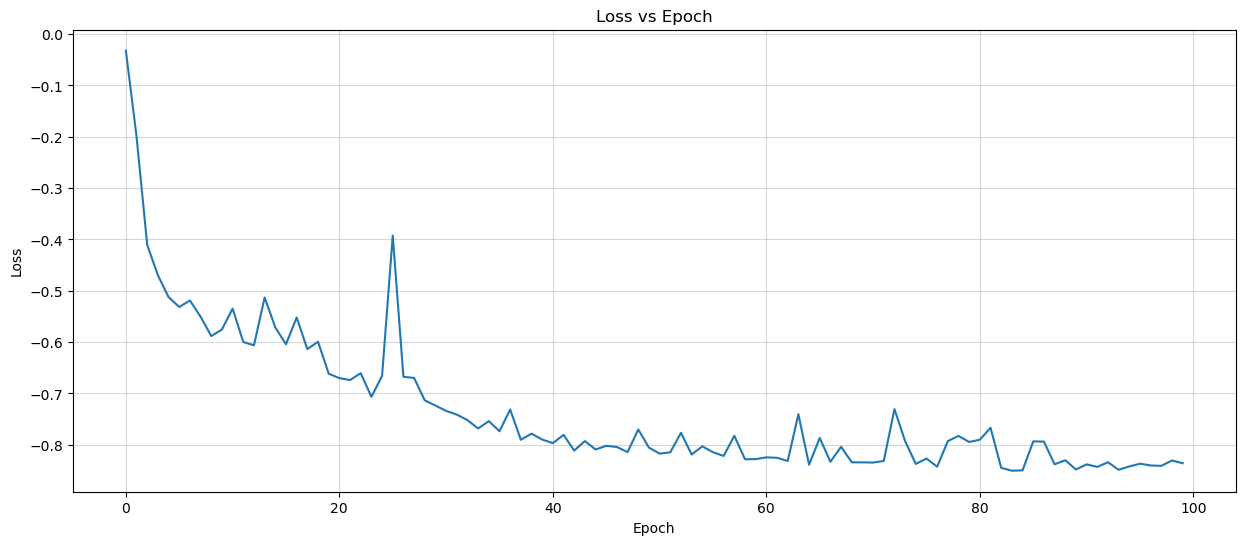

<Figure size 640x480 with 0 Axes>

In [6]:
plot_history(ckpt_path, "./train_history.png")

In [7]:
eval_transforms = Transforms.Compose([
                        # Transforms.ToTensor(), # npy loader returns torch.Tensor
                        Transforms.CenterCrop(64),
                        Transforms.Normalize(mean = [0.06814773380756378, 0.21582692861557007, 0.4182431399822235],\
                                                std = [0.16798585653305054, 0.5532506108283997, 1.1966736316680908]),
                    ])
dataloader, train_loader, val_loader, test_loader \
        = get_dataloaders(data_path="../../../input/real_lenses_dataset/", \
                          train_test_indices="../../../input/indices.pkl", \
                          state=state, eval_transforms=eval_transforms)

### Finetune the pretrained model

In [8]:
set_seed(12)

student_network = torch.load("./representation_network.pth")
lp_network = Classifier(mode = "finetune", backbone = copy.deepcopy(student_network))
optimizer = torch.optim.Adam(lp_network.parameters(), lr=1e-4, weight_decay=1e-8)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-8)
# scheduler = None

In [9]:
set_seed(12)

lp_network, lp_network_best_loss = train(lp_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

[1/100] Train Loss: 0.8892, Val Loss: 0.5177, Val Accuracy: 73.02%

[2/100] Train Loss: 0.4209, Val Loss: 0.3651, Val Accuracy: 83.53%

[3/100] Train Loss: 0.3832, Val Loss: 0.3397, Val Accuracy: 85.52%

[4/100] Train Loss: 0.3547, Val Loss: 0.3953, Val Accuracy: 83.13%

[5/100] Train Loss: 0.3551, Val Loss: 0.3221, Val Accuracy: 84.72%

[6/100] Train Loss: 0.3060, Val Loss: 0.3183, Val Accuracy: 86.11%

[7/100] Train Loss: 0.3009, Val Loss: 0.3082, Val Accuracy: 86.31%

[8/100] Train Loss: 0.2896, Val Loss: 0.3311, Val Accuracy: 86.11%

[9/100] Train Loss: 0.2686, Val Loss: 0.3058, Val Accuracy: 86.71%

[10/100] Train Loss: 0.2619, Val Loss: 0.2992, Val Accuracy: 85.91%

[11/100] Train Loss: 0.2924, Val Loss: 0.3652, Val Accuracy: 85.32%

[12/100] Train Loss: 0.2932, Val Loss: 0.2976, Val Accuracy: 87.10%

[13/100] Train Loss: 0.2680, Val Loss: 0.3065, Val Accuracy: 87.50%

[14/100] Train Loss: 0.2499, Val Loss: 0.2693, Val Accuracy: 87.30%

[15/100] Train Loss: 0.2356, Val Loss: 0.27

### Test scores when the model is run on the test dataset 

In [14]:
from utils.eval import test_
output, y_true, acc, auc = test_(lp_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       264        |          29         |
| true nonlenses |        21        |         279         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 91.5683% |
|    loss   |  0.0028  |
| auc score |  0.9651  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9263  | 0.9010 |  0.9135 |   293   |
|   nonlenses    |   0.9058  | 0.9300 |  0.9178 |   300   |
| macro averaged |   0.9161  | 0.9155 |  0.9156 |         |
+----------------+-----------+--------+---------+---------+


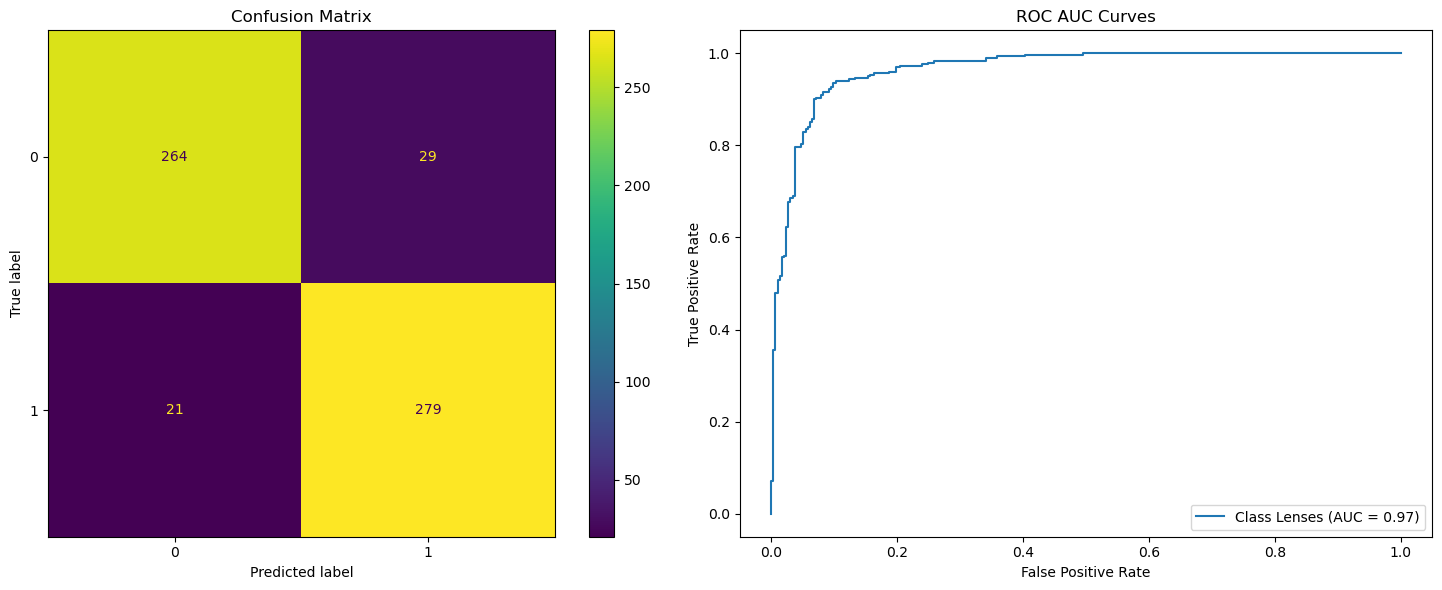

In [15]:
plot_cm_roc(output, y_true)

### Test scores when the model is run on the entire dataset 

In [16]:
output, y_true, acc, auc = test_(lp_network, dataloader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       1893       |          56         |
| true nonlenses |        48        |         1952        |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 97.3664% |
|    loss   |  0.0069  |
| auc score |  0.9931  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9753  | 0.9713 |  0.9733 |   1949  |
|   nonlenses    |   0.9721  | 0.9760 |  0.9741 |   2000  |
| macro averaged |   0.9737  | 0.9736 |  0.9737 |         |
+----------------+-----------+--------+---------+---------+


In [17]:
with open("./classifier_network.pth", "wb") as f:
    pickle.dump(lp_network, f)